## Image segmentation with CamVid

Creating a colour coded picture where all the pixels of an object have the same colour.

A little classification problem for every single pixel in every single image - Segmentation.

To build a segmentation model, you actually need a dataset with every pixel labelled.

Useful in life sciences/medicine, self driving tech etc.

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

In [0]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'fastai-v3/'

Mounted at /content/gdrive


In [0]:
path = Path(base_dir + 'camvid')
path = path/'camvid'

There are 2 folders 'labels' and 'images'

In [0]:
# path = untar_data(URLs.CAMVID, dest = path)
path.ls()

[PosixPath('/content/gdrive/My Drive/fastai-v3/camvid/camvid/labels'),
 PosixPath('/content/gdrive/My Drive/fastai-v3/camvid/camvid/codes.txt'),
 PosixPath('/content/gdrive/My Drive/fastai-v3/camvid/camvid/valid.txt'),
 PosixPath('/content/gdrive/My Drive/fastai-v3/camvid/camvid/images')]

In [0]:
path_lbl = path/'labels'
path_img = path/'images'

## Subset classes

In [0]:
# path = Path('./data/camvid-small')

# def get_y_fn(x): return Path(str(x.parent)+'annot')/x.name

# codes = array(['Sky', 'Building', 'Pole', 'Road', 'Sidewalk', 'Tree',
#     'Sign', 'Fence', 'Car', 'Pedestrian', 'Cyclist', 'Void'])

# src = (SegmentationItemList.from_folder(path)
#        .split_by_folder(valid='val')
#        .label_from_func(get_y_fn, classes=codes))

# bs=8
# data = (src.transform(get_transforms(), tfm_y=True)
#         .databunch(bs=bs)
#         .normalize(imagenet_stats))

## Data

In [0]:
fnames = get_image_files(path_img)
fnames[:3]

[PosixPath('/content/gdrive/My Drive/fastai-v3/camvid/camvid/images/0001TP_007620.png'),
 PosixPath('/content/gdrive/My Drive/fastai-v3/camvid/camvid/images/0006R0_f01800.png'),
 PosixPath('/content/gdrive/My Drive/fastai-v3/camvid/camvid/images/0006R0_f02160.png')]

In [0]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

[PosixPath('/content/gdrive/My Drive/fastai-v3/camvid/camvid/labels/0006R0_f02940_P.png'),
 PosixPath('/content/gdrive/My Drive/fastai-v3/camvid/camvid/labels/Seq05VD_f01650_P.png'),
 PosixPath('/content/gdrive/My Drive/fastai-v3/camvid/camvid/labels/0016E5_00750_P.png')]

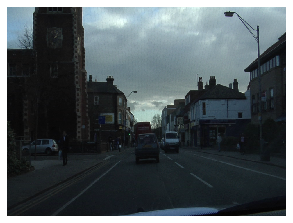

In [0]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))

In [0]:
path_1 = Path('/content/gdrive/My Drive/fastai-v3/camvid/camvid/labels/0006R0_f02940_P.png')
print(path_1.stem)
print(path_1.suffix)

0006R0_f02940_P
.png


Function that converts from the image file names to the equivalent label file names.

In [0]:
get_y_fn = lambda x: path_lbl/f'{x.stem}_P{x.suffix}'

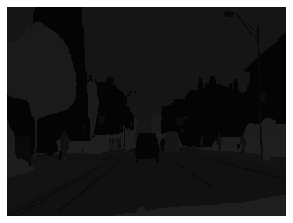

In [0]:
mask = open_image(get_y_fn(img_f))
mask.show(figsize=(5,5))

The mask is not an usual image - does not contain pixel values, it contains integers.

Hence we use open_mask() and not open_image()

mask.show will automatically color code it some appropriate way.

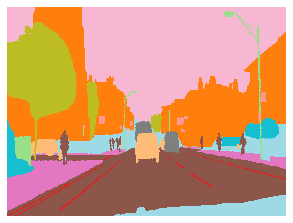

In [0]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

Size of the images - 720 x 960

In [0]:
src_size = np.array(mask.shape[1:])
src_size,mask.data

(array([720, 960]), tensor([[[21, 21, 21,  ..., 21, 21, 21],
          [21, 21, 21,  ..., 21, 21, 21],
          [21, 21, 21,  ..., 21, 21, 21],
          ...,
          [10, 10, 10,  ..., 30, 30, 30],
          [10, 10, 10,  ..., 30, 30, 30],
          [10, 10, 10,  ..., 30, 30, 30]]]))

codes.txt helps us map integer to object.

In [0]:
codes = np.loadtxt(path/'codes.txt', dtype=str); codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

## Datasets

Creating DataBunch object with DataBlock API

In [0]:
size = src_size//2

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=8
else:           bs=4
print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=8, have 16270MB of GPU RAM free


Smaller batch size because, we have a classifier for every pixel, needing a lot more GPU

In [0]:
size

array([360, 480])

https://docs.fast.ai/data_block.html#ItemList

SegmentationItemList is a subclass of ImageList which inherits from ItemList

In [0]:
src = (SegmentationItemList.from_folder(path_img)
       .split_by_fname_file('../valid.txt')
       .label_from_func(get_y_fn, classes=codes))

The splitting into validation and train is not done randomly so as to avoid contiguous frames from the video being in train and validation which would be easy for the model.

In [0]:
type(src)

fastai.data_block.LabelLists

Transform y as well.

In [0]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

show batch method combines image and label and it will color code the photo.

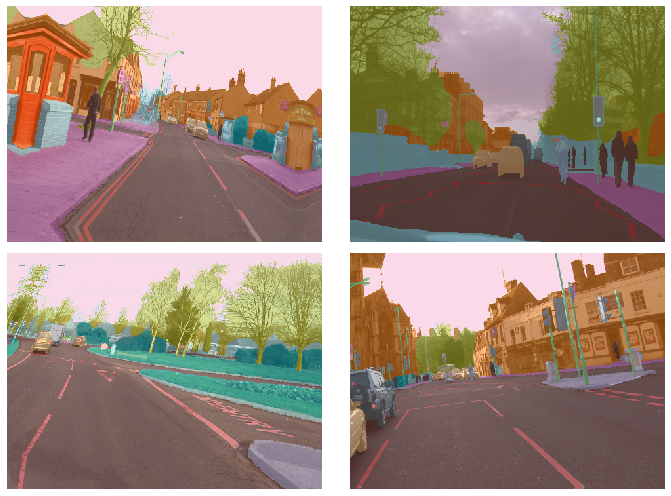

In [0]:
data.show_batch(2, figsize=(10,7))

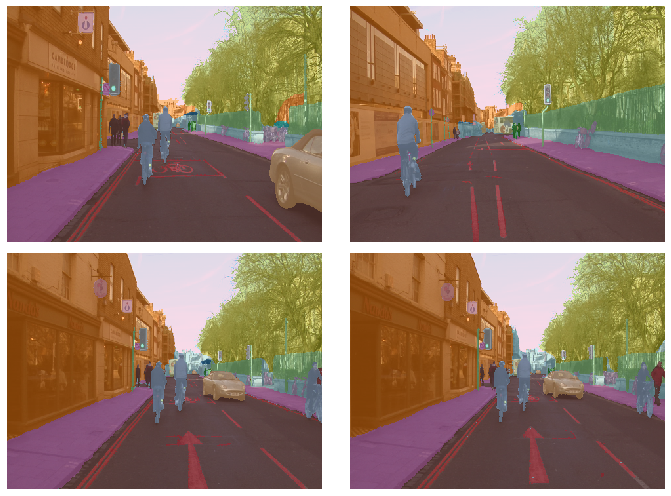

In [0]:
data.show_batch(2, figsize=(10,7), ds_type=DatasetType.Valid)

## Model

In [0]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [0]:
void_code

30

In [0]:
metrics=acc_camvid
# metrics=accuracy

In [0]:
wd=1e-2

unet_learner instead of cnn_learner

In [0]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


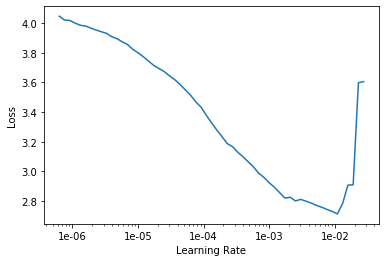

In [0]:
lr_find(learn)
learn.recorder.plot()

In [0]:
lr=1e-5

In [0]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,acc_camvid,time
0,4.789769,4.136330,0.002157,01:38
1,3.995222,3.457025,0.035377,00:59
2,3.384170,2.946510,0.246440,01:00
3,2.579341,1.909238,0.586633,01:00


KeyboardInterrupt: ignored

In [0]:
lr=3e-3

In [0]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.524914,0.459163,0.871650,00:59
1,0.510685,0.437482,0.876712,00:59
2,0.499070,0.434827,0.880098,00:59
3,0.491974,0.384391,0.887192,00:59
4,0.486624,0.409949,0.893445,01:00
5,0.497393,0.399509,0.880564,01:00
6,0.498302,0.444009,0.890136,01:01
7,0.473760,0.419842,0.881275,00:59
8,0.454528,0.473093,0.880882,00:59
9,0.410746,0.326376,0.907911,00:59


In [0]:
learn.save('stage-1')

In [0]:
learn.load('stage-1');

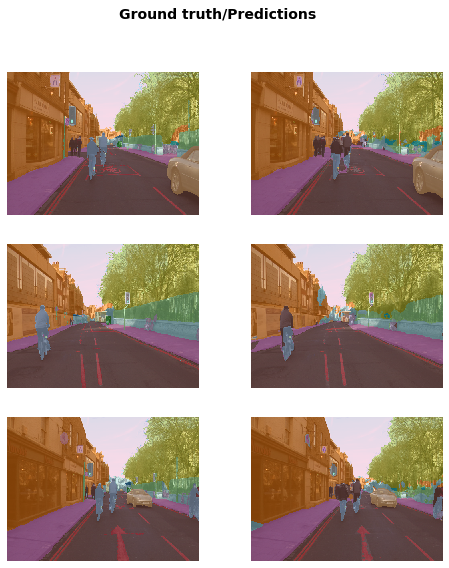

In [0]:
learn.show_results(rows=3, figsize=(8,9))

In [0]:
learn.unfreeze()

In [0]:
lrs = slice(lr/400,lr/4)

In [0]:
learn.fit_one_cycle(12, lrs, pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.360947,0.316794,0.910754,01:00
1,0.357673,0.309005,0.913346,01:01
2,0.351112,0.311701,0.911851,01:01
3,0.347270,0.322194,0.908508,01:01
4,0.335406,0.298070,0.914932,01:01
5,0.328359,0.302560,0.918099,01:01
6,0.325573,0.309032,0.914912,01:01
7,0.319009,0.316556,0.914901,01:00
8,0.310531,0.279418,0.922053,01:00
9,0.307306,0.278734,0.923389,01:00


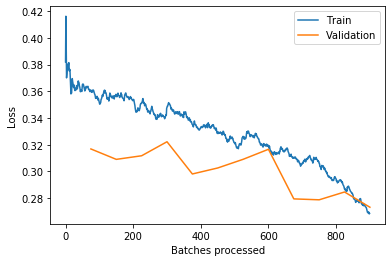

In [0]:
learn.recorder.plot_losses()

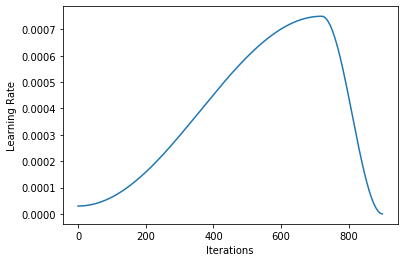

In [0]:
learn.recorder.plot_lr()

The idea of decreasing the learning rate during training is called learning rate annealing. You want your learning rate to go down so that as you get closer, you take smaller and smaller steps.

But the idea of gradually increasing it at the start is much more recent. You want a learning rate that's high enough to jump over the bumps, but once you get close to the best answer, you don't want to be just jumping backwards and forwards between bumps.

So when you call fit one cycle, you're actually passing in a maximum learning rate.

In [0]:
learn.save('stage-2');

## Go big

You may have to restart your kernel and come back to this stage if you run out of memory, and may also need to decrease `bs`.

In [0]:
learn.destroy()

size = src_size

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=3
else:           bs=1
print(f"using bs={bs}, have {free}MB of GPU RAM free")

this Learner object self-destroyed - it still exists, but no longer usable
using bs=3, have 15569MB of GPU RAM free


In [0]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [0]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

In [0]:
learn.load('stage-2');

The learn object now has same weights as before but the data size is double.

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


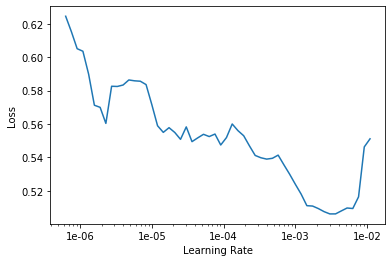

In [0]:
lr_find(learn)
learn.recorder.plot()

In [0]:
lr=1e-3

In [0]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.408242,0.334704,0.911924,03:38
1,0.371057,0.312518,0.916616,03:35
2,0.355342,0.302657,0.920550,03:35
3,0.344042,0.308224,0.917758,03:35
4,0.339049,0.352203,0.912544,03:34
5,0.346638,0.306030,0.923714,03:35
6,0.323963,0.296653,0.918403,03:35
7,0.320025,0.283150,0.925767,03:35
8,0.289411,0.277970,0.927771,03:35
9,0.246692,0.255279,0.931671,03:35


In [0]:
learn.save('stage-1-big')

In [0]:
learn.load('stage-1-big')

Learner(data=ImageDataBunch;

Train: LabelList (600 items)
x: SegmentationItemList
Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960)
y: SegmentationLabelList
ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960)
Path: /content/gdrive/My Drive/fastai-v3/camvid/camvid/images;

Valid: LabelList (101 items)
x: SegmentationItemList
Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960)
y: SegmentationLabelList
ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960)
Path: /content/gdrive/My Drive/fastai-v3/camvid/camvid/images;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, 

In [0]:
learn.unfreeze()

In [0]:
lrs = slice(1e-6,lr/10)

In [0]:
learn.fit_one_cycle(10, lrs)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.248842,0.259832,0.931439,03:42
1,0.237904,0.246485,0.933379,03:42
2,0.242919,0.257504,0.931322,03:42
3,0.229971,0.262108,0.930581,03:41
4,0.229712,0.270042,0.928734,03:42
5,0.223239,0.248415,0.933236,03:42
6,0.217137,0.246456,0.933587,03:42
7,0.222076,0.244807,0.934918,03:42
8,0.215850,0.248745,0.933960,03:42
9,0.216333,0.250051,0.933637,03:42


In [0]:
learn.save('stage-2-big')

In [0]:
learn.load('stage-2-big');

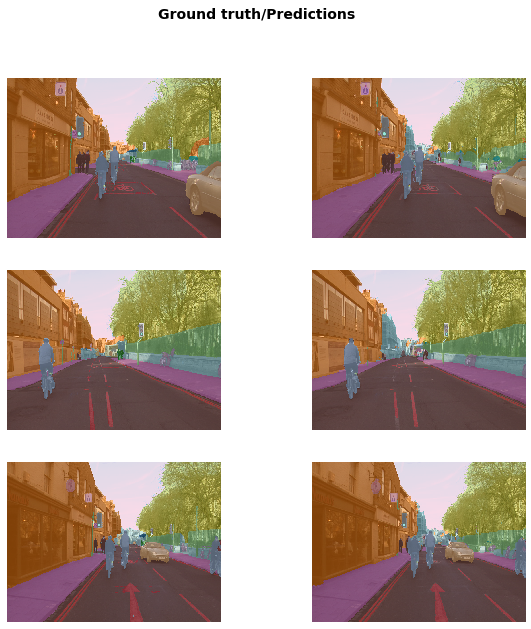

In [0]:
learn.show_results(rows=3, figsize=(10,10))

## fin